# Introduction

In this notebook, we **fine-tune and test** **a pre-trained sentence transformer model on the ADEPT dataset**.

ADEPT dataset: https://aclanthology.org/2021.acl-long.553/

Model:
* MPNet: https://huggingface.co/sentence-transformers/all-mpnet-base-v2

Here we are going to demonstrate the fine-tuning and testing process.

# Setup

In [39]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Tuple
import random
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample

In [40]:
# switch model here: currently only supports all-mpnet-base-v2
model_name = "all-mpnet-base-v2"
# switch between balanced and full dataset
balanced = True
run_ID = 9

Time formatting function

In [41]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Set random seed values for reproducibility

In [42]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Introduce GPU

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Read the data

In [44]:
train = pd.read_json('../datasets/adept/train-dev-test-split/train.json')
dev = pd.read_json('../datasets/adept/train-dev-test-split/val.json')
test = pd.read_json('../datasets/adept/train-dev-test-split/test.json')

train['set'] = 'train'
dev['set'] = 'dev'
test['set'] = 'test'
df = pd.concat([train, dev, test])

In [45]:
df.head()

,sentence1,sentence2,modifier,noun,label,idx,set
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,3,13484,train
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,2,2620,train
2,A scene is painted.,A negative scene is painted.,negative,scene,2,3324,train
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,2,10610,train
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,2,14917,train


In [46]:
df['set'].value_counts()

set
train    12892
test      1612
dev       1611
Name: count, dtype: int64

Only keep label classes 1, 2 and 3 (comparison labels). Map them to 0, 1 and 2 for training convenience:

* 1 => 0
* 2 => 1
* 3 => 2

In [47]:
df = df[df['label'].isin([1, 2, 3])]
df['label'].value_counts()

label
2    10805
1     1868
3     1132
Name: count, dtype: int64

Since the sentence transformer only outputs a distance metric between embeddings,
we have to take an extra step to map the outputs to our classes.
To make that easier we have for now chosen to convert our classes to values
ranging from 0 to 1, as this is similar to the original output range of the model.


We map class 1 to 0, class 2 to 0.5 and class 3 to 1

In [48]:
# map the labels to numbers between 1 and 0
df['label'] = df['label'] * 0.5
df['label'] -= 0.5
df['label'].value_counts()

label
0.5    10805
0.0     1868
1.0     1132
Name: count, dtype: int64

Filter out duplicated data points

In [49]:
df = df.drop_duplicates(subset=['sentence2'], keep='first')
df['label'].value_counts()

label
0.5    10800
0.0     1866
1.0     1129
Name: count, dtype: int64

# Class balance

In [50]:
train = df[df['set'] == 'train']
dev = df[df['set'] == 'dev']
test = df[df['set'] == 'test']

In [51]:
train['label'].value_counts()

label
0.5    8631
0.0    1503
1.0     926
Name: count, dtype: int64

The training data is heavily skewed towards class 1. As an option, we can balance the training data by randomly sampling 1500 examples from this class instead of using all of its samples

In [52]:
balance = True  # set to False to use the original, unbalanced training data

if balanced:
    train = pd.concat([
        train[train['label'].isin([0, 1])],
        train[train['label'] == 0.5].sample(1500, random_state=seed_val)
    ])
train['label'].value_counts()

label
0.0    1503
0.5    1500
1.0     926
Name: count, dtype: int64

In [53]:
train.shape

(3929, 7)

Save the data frame to make the results reproducible

In [54]:
train.to_csv('./datasets/adept/train_comparison_balanced.csv', index=False)

In [55]:
train = pd.read_csv(f'./datasets/adept/train_comparison_balanced.csv')
train.head()

,sentence1,sentence2,modifier,noun,label,idx,set
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,1.0,13484,train
1,Something that might happen as a consequence o...,Something that might happen as a consequence o...,evocative,singing,0.0,5134,train
2,Art is for enjoyment.,Natural art is for enjoyment.,natural,art,1.0,1008,train
3,Sometimes work causes exhaustion.,Sometimes former work causes exhaustion.,former,work,0.0,6706,train
4,A home is for a family.,A hot home is for a family.,hot,home,0.0,8797,train


In [56]:
df = pd.concat([train, dev, test])
df.reset_index(inplace=True, drop=True)
df.shape

(6664, 7)

# Preparing the Input

Our model input contains both sentences in a list, as well as the target label

In [57]:
df['sent_concat'] = df.apply(lambda row: InputExample(texts=[row['sentence1'], row['sentence2']], label=row['label']), axis=1)

Since the sentence-transformer model creates it's own embeddings from the data, we don't need a tokenizer.

We create dataframes containing the correctly formatted input

In [58]:
# train
train_docs = df[df['set'] == 'train']['sent_concat'].to_list()

# validation (dev)
dev_docs = df[df['set'] == 'dev']['sent_concat'].to_list()

# test
test_docs = df[df['set'] == 'dev']['sent_concat'].to_list()

Create a `torch` dataset and dataloader to conveniently load it into the model

In [59]:
batch_size = 16

# train
train_dataloader = DataLoader(
            train_docs,
            sampler=RandomSampler(train_docs),  # Select batches randomly
            batch_size=batch_size
        )

# validation (dev)
validation_dataloader = DataLoader(
            dev_docs,
            sampler=SequentialSampler(dev_docs),  # Pull out batches sequentially
            batch_size=batch_size
        )

print(f'train:  {len(train_docs)} data points, {len(train_dataloader)} batches')
print(f'validation (dev): {len(dev_docs)} data points, {len(validation_dataloader)} batches')

train:  3929 data points, 246 batches
validation (dev): 1355 data points, 85 batches


# Model

With the data at the ready, we load the pre-trained model

In [60]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

Initialize `AdamW` optimizer and learning rate scheduler. We are going to train for 4 epochs

In [61]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8  # default
                )

train_loss = losses.CosineSimilarityLoss(model=model)

# Training

## Training loop

In [62]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime

logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

model_name = 'all-mpnet-base-v2'
train_batch_size = 16
num_epochs = 4
model_save_path = 'output/training_stsbenchmark_continue_training-'+model_name+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

logging.info("Read STSbenchmark train dataset")

logging.info("Read STSbenchmark dev dataset")

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_docs, name='sts-dev')

# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)
model = SentenceTransformer(model_save_path)

2024-01-17 21:19:57 - Read STSbenchmark train dataset
2024-01-17 21:19:57 - Read STSbenchmark dev dataset
2024-01-17 21:19:57 - Warmup-steps: 99


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [01:34<?, ?it/s]

2024-01-17 21:21:32 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 0:


Epoch:   0%|          | 0/4 [01:43<?, ?it/s]

2024-01-17 21:21:40 - Cosine-Similarity :	Pearson: 0.4187	Spearman: 0.3995
2024-01-17 21:21:40 - Manhattan-Distance:	Pearson: 0.4121	Spearman: 0.3976
2024-01-17 21:21:40 - Euclidean-Distance:	Pearson: 0.4132	Spearman: 0.3995
2024-01-17 21:21:40 - Dot-Product-Similarity:	Pearson: 0.4187	Spearman: 0.3995
2024-01-17 21:21:40 - Save model to output/training_stsbenchmark_continue_training-all-mpnet-base-v2-2024-01-17_21-19-57


Epoch:  25%|██▌       | 1/4 [03:17<05:11, 103.99s/it]

2024-01-17 21:23:15 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 1:


Epoch:  25%|██▌       | 1/4 [03:25<05:11, 103.99s/it]

2024-01-17 21:23:23 - Cosine-Similarity :	Pearson: 0.4302	Spearman: 0.4108
2024-01-17 21:23:23 - Manhattan-Distance:	Pearson: 0.4252	Spearman: 0.4103
2024-01-17 21:23:23 - Euclidean-Distance:	Pearson: 0.4257	Spearman: 0.4108
2024-01-17 21:23:23 - Dot-Product-Similarity:	Pearson: 0.4302	Spearman: 0.4108
2024-01-17 21:23:23 - Save model to output/training_stsbenchmark_continue_training-all-mpnet-base-v2-2024-01-17_21-19-57


Epoch:  50%|█████     | 2/4 [05:00<03:26, 103.29s/it]

2024-01-17 21:24:58 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 2:


Epoch:  50%|█████     | 2/4 [05:08<03:26, 103.29s/it]

2024-01-17 21:25:06 - Cosine-Similarity :	Pearson: 0.4310	Spearman: 0.4184
2024-01-17 21:25:06 - Manhattan-Distance:	Pearson: 0.4245	Spearman: 0.4180
2024-01-17 21:25:06 - Euclidean-Distance:	Pearson: 0.4245	Spearman: 0.4184
2024-01-17 21:25:06 - Dot-Product-Similarity:	Pearson: 0.4310	Spearman: 0.4184
2024-01-17 21:25:06 - Save model to output/training_stsbenchmark_continue_training-all-mpnet-base-v2-2024-01-17_21-19-57


Epoch:  75%|███████▌  | 3/4 [06:44<01:43, 103.25s/it]

2024-01-17 21:26:42 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 3:


Epoch: 100%|██████████| 4/4 [06:52<00:00, 103.18s/it]


2024-01-17 21:26:50 - Cosine-Similarity :	Pearson: 0.4249	Spearman: 0.4121
2024-01-17 21:26:50 - Manhattan-Distance:	Pearson: 0.4192	Spearman: 0.4115
2024-01-17 21:26:50 - Euclidean-Distance:	Pearson: 0.4193	Spearman: 0.4121
2024-01-17 21:26:50 - Dot-Product-Similarity:	Pearson: 0.4249	Spearman: 0.4121
2024-01-17 21:26:50 - Load pretrained SentenceTransformer: output/training_stsbenchmark_continue_training-all-mpnet-base-v2-2024-01-17_21-19-57
2024-01-17 21:26:51 - Use pytorch device: cuda


In [63]:
# put the model in evaluation mode and move model parameters back to the cpu, in case they were on the gpu before
model.eval()
model.cpu()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

# Validation

To test model performance, we split the test and development data into two lists each, one containing sentence 1 of every instance, the other containing sentence 2

In [65]:
# currently uses test set for validation, can change test to dev
test_sent1 = df[df['set'] == 'test']['sentence1'].to_list()
test_sent2 = df[df['set'] == 'test']['sentence2'].to_list()
test_labels = df[df['set'] == 'test']['label'].to_list()
dev_sent1 = df[df['set'] == 'dev']['sentence1'].to_list()
dev_sent2 = df[df['set'] == 'dev']['sentence2'].to_list()
dev_labels = df[df['set'] == 'dev']['label'].to_list()

We compute the embeddings for each list and calculate their cosine similarity to extract the predictions.

In [66]:
#Compute embedding for both lists
test_embeddings1 = model.encode(test_sent1, convert_to_tensor=True)
test_embeddings2 = model.encode(test_sent2, convert_to_tensor=True)
dev_embeddings1 = model.encode(dev_sent1, convert_to_tensor=True)
dev_embeddings2 = model.encode(dev_sent2, convert_to_tensor=True)
#Compute cosine-similarities
test_cosine_scores = util.cos_sim(test_embeddings1, test_embeddings2)
dev_cosine_scores = util.cos_sim(dev_embeddings1, dev_embeddings2)

Batches: 100%|██████████| 43/43 [00:03<00:00, 11.91it/s]


To see how the model works, let's output some sample sentence pairs with their cosine similarity scores.

In [67]:
#Output sample pairs with their score
for i in range(5):
    print("{} - {} \t\t {} \t\t Score: {:.4f}".format(test_labels[i], test_sent1[i], test_sent2[i], test_cosine_scores[i][i]))

1.0 - Urine is tested to check for disease. 		 Dark urine is tested to check for disease. 		 Score: 0.2483
0.0 - News is relevant. 		 False news is relevant. 		 Score: 0.1943
0.5 - Rice is stirred. 		 Fresh rice is stirred. 		 Score: 0.7639
0.5 - Plastic is made of carbon. 		 Colorful plastic is made of carbon. 		 Score: 0.3166
0.5 - Sometimes hiking causes a smile. 		 Sometimes abundant hiking causes a smile. 		 Score: 0.8285


We map the continous cosine similarities to the three classes


Currently this is done using an arbitrary cut-off point,
later we want to calculate a mean score for each class
and use the distance to that score to determine the classes instead

In [68]:
test_y_pred = []
for i in range(len(test_sent1)):
    if test_cosine_scores[i][i] < 0.25:
        test_y_pred.append(0)
    elif test_cosine_scores[i][i] > 0.75:
        test_y_pred.append(2)
    else: test_y_pred.append(1)

dev_y_pred = []
for i in range(len(dev_sent1)):
    if dev_cosine_scores[i][i] < 0.25:
        dev_y_pred.append(0)
    elif dev_cosine_scores[i][i] > 0.75:
        dev_y_pred.append(2)
    else: dev_y_pred.append(1)

In [69]:
test_y_true = [x*2 for x in df[df['set'] == 'test']['label'].to_list()]
dev_y_true = [x*2 for x in df[df['set'] == 'dev']['label'].to_list()]

# Plots & Statistics

The authors of the original ADEPT paper plot the confusion matrix to illustrate the performance on the development (validation) set (see p. 7124, fig. 2 & 3). To compare our results to theirs, we will plot a confusion matrix as well

In [70]:
# normalize='all' -- same as in Adept paper
# normalize='true' -- normalize along rows
norm_setting = 'true'

test_conf_matr = confusion_matrix(test_y_true, test_y_pred, normalize=norm_setting)
test_conf_matr = pd.DataFrame(test_conf_matr, columns=['Less likely', 'Equally likely', 'More likely'],
                             index=['Less likely', 'Equally likely', 'More likely'])

dev_conf_matr = confusion_matrix(dev_y_true, dev_y_pred, normalize=norm_setting)
dev_conf_matr = pd.DataFrame(dev_conf_matr, columns=['Less likely', 'Equally likely', 'More likely'],
                             index=['Less likely', 'Equally likely', 'More likely'])

Text(0.5, 20.049999999999997, 'Predicted')

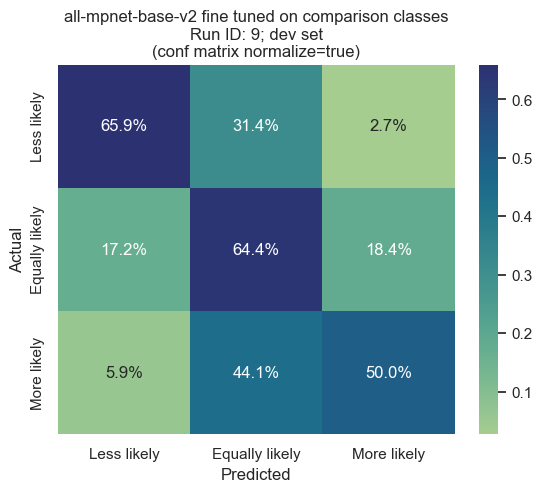

In [71]:
sns.heatmap(dev_conf_matr, cmap='crest', annot=True, fmt=".1%")
plt.title(f"""{model_name} fine tuned on comparison classes
Run ID: {run_ID}; dev set
(conf matrix normalize={norm_setting})""")
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 20.049999999999997, 'Predicted')

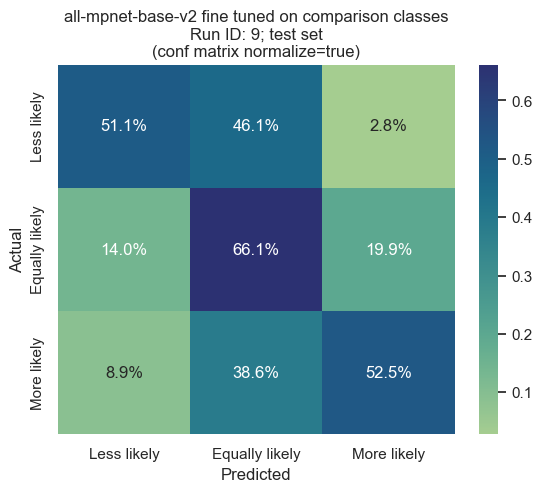

In [72]:
sns.heatmap(test_conf_matr, cmap='crest', annot=True, fmt=".1%")
plt.title(f"""{model_name} fine tuned on comparison classes
Run ID: {run_ID}; test set
(conf matrix normalize={norm_setting})""")
plt.ylabel('Actual')
plt.xlabel('Predicted')

To otherwise evaluate the performance, we use macro F1 score, weighted F1 score and one-vs-all class-wise F1 scores

Macro F1

In [73]:
print('Dev set: macro F1 = {:.3}'.format(f1_score(dev_y_true, dev_y_pred, average='macro')))
print('Test set: macro F1 = {:.3}'.format(f1_score(test_y_true, test_y_pred, average='macro')))

Dev set: macro F1 = 0.506
Test set: macro F1 = 0.483


Weighted F1

In [74]:
print('Dev set: weighted F1 = {:.3}'.format(f1_score(dev_y_true, dev_y_pred, average='weighted')))
print('Test set: weighted F1 = {:.3}'.format(f1_score(test_y_true, test_y_pred, average='weighted')))

Dev set: weighted F1 = 0.672
Test set: weighted F1 = 0.671


F1 "one vs all" for each class

In [75]:
def f1_one_vs_all(true, pred, class_label):
  true = [0 if v != class_label else 1 for v in true]
  pred = [0 if v != class_label else 1 for v in pred]
  return f1_score(true, pred)

In [76]:
f1_less, f1_eq, f1_more = f1_one_vs_all(dev_y_true, dev_y_pred, class_label=0), \
                          f1_one_vs_all(dev_y_true, dev_y_pred, class_label=1), \
                          f1_one_vs_all(dev_y_true, dev_y_pred, class_label=2)
f1_less, f1_eq, f1_more
print(f"""Dev set: one-vs-all F1
1 - Less likely: {f1_less:.2f}
2 - Equally likely: {f1_eq:.2f}
3 - More likely: {f1_more:.2f}
""")

Dev set: one-vs-all F1
1 - Less likely: 0.49
2 - Equally likely: 0.74
3 - More likely: 0.29



In [77]:
f1_less, f1_eq, f1_more = f1_one_vs_all(test_y_true, test_y_pred, class_label=0), \
                          f1_one_vs_all(test_y_true, test_y_pred, class_label=1), \
                          f1_one_vs_all(test_y_true, test_y_pred, class_label=2)
f1_less, f1_eq, f1_more
print(f"""Test set: one-vs-all F1
1 - Less likely: {f1_less:.2f}
2 - Equally likely: {f1_eq:.2f}
3 - More likely: {f1_more:.2f}""")

Test set: one-vs-all F1
1 - Less likely: 0.42
2 - Equally likely: 0.75
3 - More likely: 0.28


As we could not find a good way to calculate the auc-roc score for cosine similarities, the auc-roc score is missing from this evaluation.

Crossevaluation on the test set:

In [ ]:
step = 101
df_list = []
full_test_y_true = []
full_test_y_pred = []
all_macroF1 = 0
all_label1_F1 = 0
all_label2_F2 = 0
all_label3_F3 = 0
for i in range(1, len(df[df['set'] == 'test'].loc[(df['label'] == 0.5)]['label'].to_list())+1, step):
    new_df = df[df['set'] == 'test'].loc[(df['label'] == 0)][i:i+step]
    new_df = pd.concat([new_df, df[df['set'] == 'test'].loc[(df['label'] == 0.5)][i:i+step]]) 
    new_df = pd.concat([new_df, df[df['set'] == 'test'].loc[(df['label'] == 1)][i:i+step]]) 
    for i in [0, 0.5, 1]:
        if len(new_df.loc[(new_df['label'] == i)]['label'].to_list()) < step:
            wrap_around = step - len(new_df.loc[(new_df['label'] == i)]['label'].to_list())
            new_df = pd.concat([new_df, df[df['set'] == 'test'].loc[(df['label'] == i)][:wrap_around]])
    new_df = new_df.drop(columns=['sent_concat'])

    # evaluation
    test_sent1 = new_df['sentence1'].to_list()
    test_sent2 = new_df['sentence2'].to_list()
    test_labels = new_df['label'].to_list()

    #Compute embedding for both lists
    test_embeddings1 = model.encode(test_sent1, convert_to_tensor=True)
    test_embeddings2 = model.encode(test_sent2, convert_to_tensor=True)
    
    #Compute cosine-similarities
    test_cosine_scores = util.cos_sim(test_embeddings1, test_embeddings2)

    # map the continous cosine similarities to the three classes
    test_y_pred = []
    for i in range(len(test_sent1)):
        if test_cosine_scores[i][i] <= 0.33:
            test_y_pred.append(0)
        elif test_cosine_scores[i][i] >= 0.66:
            test_y_pred.append(2)
        else: test_y_pred.append(1)
    test_y_true = [x*2 for x in new_df['label'].to_list()]
    
    full_test_y_true.extend(test_y_true)
    full_test_y_pred.extend(test_y_pred)
    
    macro_f1 = f1_score(test_y_true, test_y_pred, average='macro')
    all_macroF1 += macro_f1

    f1_less, f1_eq, f1_more = f1_one_vs_all(test_y_true, test_y_pred, class_label=0), \
                            f1_one_vs_all(test_y_true, test_y_pred, class_label=1), \
                            f1_one_vs_all(test_y_true, test_y_pred, class_label=2)
    all_label1_F1 += f1_less
    all_label2_F2 += f1_eq
    all_label3_F3 += f1_more

print()
print()
print("average stats")
count = 11
avr_MacroF1 = all_macroF1 / count
print("macro F1:")
print('test set: {:.3}'.format(avr_MacroF1))
avr_label1_F1 = all_label1_F1 / count
avr_label2_F2 = all_label2_F2 / count
avr_label3_F3 = all_label3_F3 / count
print("\nclass-wise F1 scores for the test set:")
print(f'1: {avr_label1_F1:.2f}\n2: {avr_label2_F2:.2f}\n3: {avr_label3_F3:.2f}')

Batches: 100%|██████████| 10/10 [00:00<00:00, 14.85it/s]



average stats
macro F1:
test set: 0.587

class-wise F1 scores for the test set:
1: 0.65
2: 0.45
3: 0.66


In [ ]:
# normalize='all' -- same as in Adept paper
# normalize='true' -- normalize along rows
norm_setting = 'true'

test_conf_matr = confusion_matrix(full_test_y_true, full_test_y_pred, normalize=norm_setting)
test_conf_matr = pd.DataFrame(test_conf_matr, columns=['Less likely', 'Equally likely', 'More likely'],
                             index=['Less likely', 'Equally likely', 'More likely'])

Text(0.5, 20.049999999999997, 'Predicted')

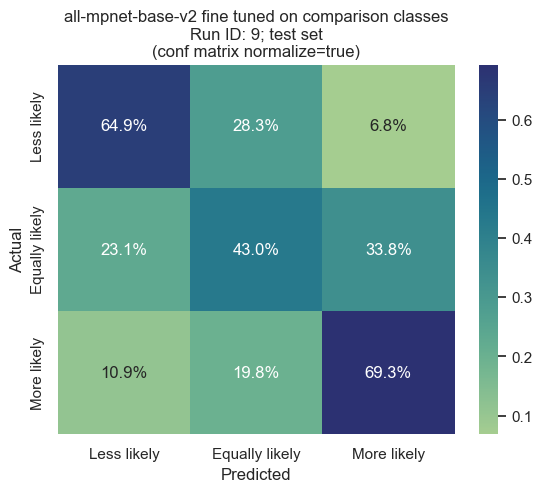

In [ ]:
sns.heatmap(test_conf_matr, cmap='crest', annot=True, fmt=".1%")
plt.title(f"""{model_name} fine tuned on comparison classes
Run ID: {run_ID}; test set
(conf matrix normalize={norm_setting})""")
plt.ylabel('Actual')
plt.xlabel('Predicted')

Save the model for later use

In [78]:
filename = model_name + "_" + str(run_ID) + "_" #+ "ep" +str(epochs) + "_"
if len(train[train['label'] == 1]) == 1500:
    filename += "balanced"
else: 
    filename += "full"
filename += ".pt"
print(filename)
# torch.save(model, filename)

all-mpnet-base-v2_9_full.pt


We will report and compare results obtained from different models in the final project documentaion